In [ ]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.utils import to_categorical

import keras.layers as L
import keras as K
import keras.layers as L
import os
import cv2
from keras import backend as K

import time

%load_ext tensorboard


In [3]:
!wget http://chaladze.com/l5/img/Linnaeus%205%20128X128.rar

--2022-12-11 16:34:02--  http://chaladze.com/l5/img/Linnaeus%205%20128X128.rar
Resolving chaladze.com (chaladze.com)... 74.208.236.157, 2607:f1c0:100f:f000::25c
Connecting to chaladze.com (chaladze.com)|74.208.236.157|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138983573 (133M) [application/rar]
Saving to: ‘Linnaeus 5 128X128.rar’

Linnaeus 5 128X128. 100%[===================>] 132.54M  11.7MB/s    in 12s     

2022-12-11 16:34:15 (11.1 MB/s) - ‘Linnaeus 5 128X128.rar’ saved [138983573/138983573]



In [4]:
!pip install unrar
!unrar x '/content/Linnaeus 5 128X128.rar'

Streaming output truncated to the last 5000 lines.
Extracting  Linnaeus 5 128X128/train/berry/825_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/826_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/827_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/828_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/829_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/82_128.jpg                     38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/830_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/831_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/832_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X128/train/berry/833_128.jpg                    38%  OK 
Extracting  Linnaeus 5 128X12

In [5]:
training_folder_dir = '/content/Linnaeus 5 128X128/train'
test_folder_dir = '/content/Linnaeus 5 128X128/test'

img_size = (128, 128)

class_names = sorted(os.listdir(training_folder_dir))
class_names

['berry', 'bird', 'dog', 'flower', 'other']

In [6]:
IMG_SIZE = 128

In [7]:
def create_dataset(data_path):
    training_data = []
    for i in range(len(class_names)):
        category = class_names[i]
        path = os.path.join(data_path, category)
        print(path)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([new_array, i])

    return training_data

In [8]:

train_data = create_dataset(training_folder_dir)
test_data = create_dataset(test_folder_dir)

/content/Linnaeus 5 128X128/train/berry
/content/Linnaeus 5 128X128/train/bird
/content/Linnaeus 5 128X128/train/dog
/content/Linnaeus 5 128X128/train/flower
/content/Linnaeus 5 128X128/train/other
/content/Linnaeus 5 128X128/test/berry
/content/Linnaeus 5 128X128/test/bird
/content/Linnaeus 5 128X128/test/dog
/content/Linnaeus 5 128X128/test/flower
/content/Linnaeus 5 128X128/test/other


In [9]:
def extract_X_y(data):
    X = []
    y = []
    for features, label in data:
        X.append(features)
        y.append(label)
    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    X = np.array(X)
    y = np.array(y)
    return X, y

In [10]:
train_X, train_y = extract_X_y(train_data)
test_X, test_y = extract_X_y(test_data)

In [11]:
train_y_eye = np.eye(5)[train_y]

# Q4

In [12]:
def inception_v2(input_img, channel_multiply=1):
    ### 1st layer
    layer_1 = L.Conv2D(16 * channel_multiply, (1, 1), padding='same', activation='relu')(input_img)
    layer_1 = L.Conv2D(16 * channel_multiply, (3, 3), padding='same', activation='relu')(layer_1)

    layer_2 = L.Conv2D(16 * channel_multiply, (1, 1), padding='same', activation='relu')(input_img)
    layer_2 = L.Conv2D(16 * channel_multiply, (5, 5), padding='same', activation='relu')(layer_2)

    layer_3 = L.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_img)
    layer_3 = L.Conv2D(16 * channel_multiply, (1, 1), padding='same', activation='relu')(layer_3)

    layer_4 = L.Conv2D(16 * channel_multiply, (1, 1), padding='same', activation='relu')(input_img)

    mid_1 = tf.keras.layers.concatenate([layer_1, layer_2, layer_3,layer_4], axis=3)
    return mid_1

In [17]:
model = None

In [18]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [19]:
num_classes = 5
input_img = L.Input(shape=(128, 128, 3))
input_img = L.Rescaling(1. / 255)(input_img)
input_img = L.RandomFlip('horizontal')(input_img)
input_img = L.RandomRotation(0.2)(input_img)

c1 = inception_v2(input_img)
p1 = L.AvgPool2D()(c1)

c2 = inception_v2(p1,2)
p2 = L.AvgPool2D(pool_size=(4, 4))(c2)

final = L.Conv2D(32,(1, 1), padding='same', activation='relu')(p2)
final = L.Flatten()(p2)
final = L.Dense(1024, activation='relu')(final)
final = L.Dense(256, activation='relu')(final)
# final = L.Dropout(0.2)(final)
final = L.Dense(num_classes, activation='softmax')(final)

model = keras.Model(inputs=[input_img], outputs=final)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 128, 128, 16  64          ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 16  64          ['input_4[0][0]']                
                                )                                                           

In [20]:
start = time.time()
my_callback = MyThresholdCallback(threshold=0.75)
history = model.fit(x=train_X, y=train_y_eye, batch_size=32, epochs=50, validation_split=0.1,
                              callbacks=[keras.callbacks.TensorBoard(),my_callback])
duration = time.time() - start

Epoch 1/50
  6/169 [>.............................] - ETA: 11s - loss: 1813.8448 - accuracy: 0.2135

169/169 [==============================] - 12s 65ms/step - loss: 95.9871 - accuracy: 0.4026 - val_loss: 2.5327 - val_accuracy: 0.1367
Epoch 2/50
169/169 [==============================] - 11s 64ms/step - loss: 1.1359 - accuracy: 0.5685 - val_loss: 2.8178 - val_accuracy: 0.0733
Epoch 3/50
169/169 [==============================] - 11s 65ms/step - loss: 0.9074 - accuracy: 0.6570 - val_loss: 1.5218 - val_accuracy: 0.4183
Epoch 4/50
169/169 [==============================] - 11s 64ms/step - loss: 0.8007 - accuracy: 0.7083 - val_loss: 3.4602 - val_accuracy: 0.1450
Epoch 5/50
169/169 [==============================] - 11s 64ms/step - loss: 0.6448 - accuracy: 0.7667 - val_loss: 3.4809 - val_accuracy: 0.2117
Epoch 6/50
169/169 [==============================] - 11s 66ms/step - loss: 0.5685 - accuracy: 0.8089 - val_loss: 2.5863 - val_accuracy: 0.4217
Epoch 7/50
169/169 [==============================] - 11s 65ms/step - loss: 0.4305 - accuracy: 0.8452 - val_loss: 3.4947 - val_accuracy: 0.3133
Ep

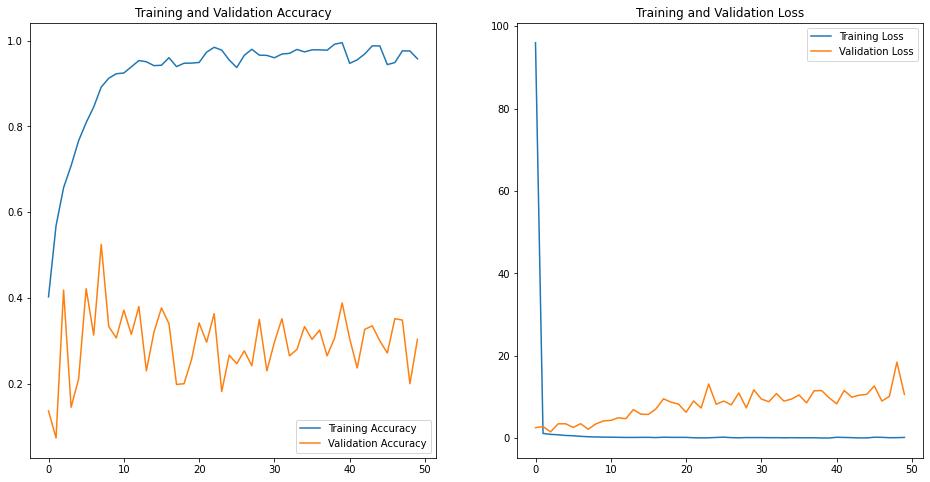

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
pred = model.predict(test_X)
pred
pred = pred.argmax(axis=1)

63/63 [==============================] - 2s 23ms/step


In [25]:
accuracy_score(test_y, pred)

0.431

In [26]:
confusion_matrix(test_y, pred)

array([[190,  34,  30, 115,  31],
       [ 51, 146,  99,  62,  42],
       [ 43,  99, 165,  45,  48],
       [ 82,  18,  23, 249,  28],
       [ 65,  71,  65,  87, 112]])

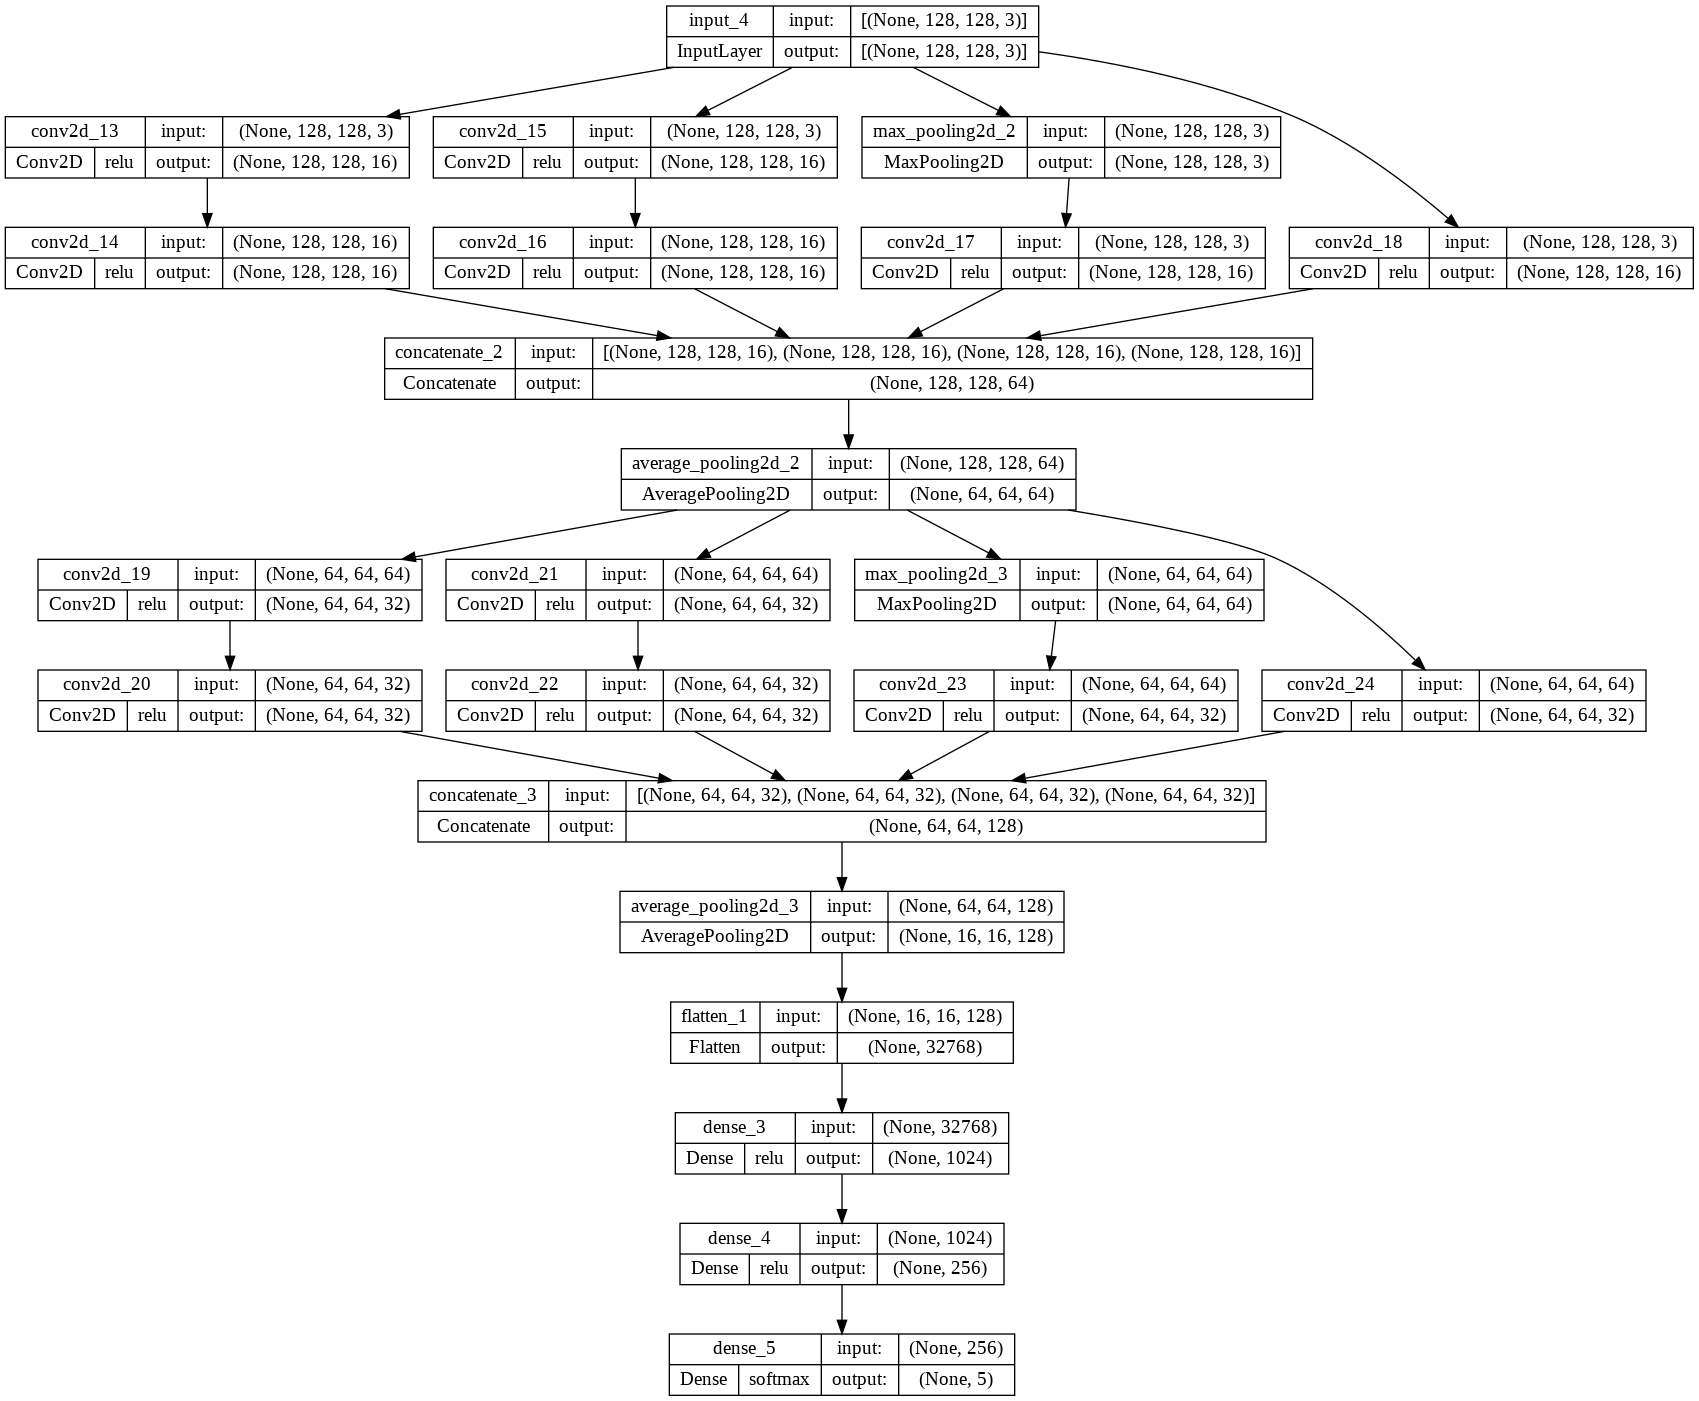

In [27]:
keras.utils.plot_model(model, show_layer_activations=True, show_shapes=True, show_layer_names=True)

# Q6

In [28]:
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz

--2022-12-11 16:53:36--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 142.250.4.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M  24.3MB/s    in 10s     

2022-12-11 16:53:48 (21.3 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [29]:

!tar -xvf '/content/flower_photos.tgz'

flower_photos/
flower_photos/roses/
flower_photos/roses/14810868100_87eb739f26_m.jpg
flower_photos/roses/1446090416_f0cad5fde4.jpg
flower_photos/roses/15319767030_e6c5602a77_m.jpg
flower_photos/roses/15032112248_30c5284e54_n.jpg
flower_photos/roses/7211616670_2d49ecb3a5_m.jpg
flower_photos/roses/15674450867_0ced942941_n.jpg
flower_photos/roses/17158274118_00ec99a23c.jpg
flower_photos/roses/14019883858_e5d2a0ec10_n.jpg
flower_photos/roses/8035908422_87220425d2_n.jpg
flower_photos/roses/14747962886_2bff6bb323_m.jpg
flower_photos/roses/4356781875_92c5cd93c0.jpg
flower_photos/roses/8524505546_b242bd4928_n.jpg
flower_photos/roses/9406573080_60eab9278e_n.jpg
flower_photos/roses/6039330368_c30ed224c4_m.jpg
flower_photos/roses/14414100710_753a36fce9.jpg
flower_photos/roses/3292434691_392071d702_n.jpg
flower_photos/roses/5273722065_c85d8543c2_m.jpg
flower_photos/roses/2215318403_06eb99176a.jpg
flower_photos/roses/172311368_49412f881b.jpg
flower_photos/roses/15255964454_0a64eb67fa.jpg
flower_pho

.ipynb_checkpoints
/content/flower_photos/.ipynb_checkpoints
daisy
/content/flower_photos/daisy


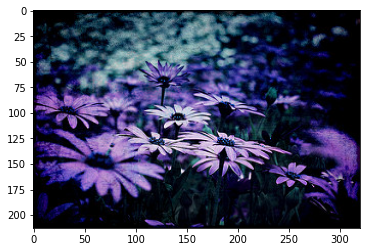

dandelion
/content/flower_photos/dandelion


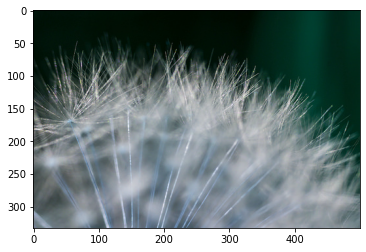

roses
/content/flower_photos/roses


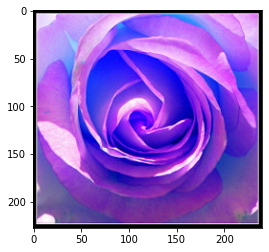

sunflowers
/content/flower_photos/sunflowers


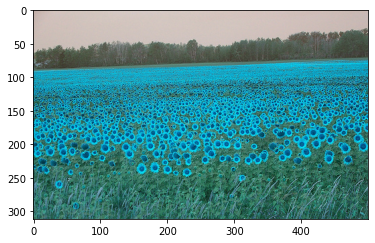

tulips
/content/flower_photos/tulips


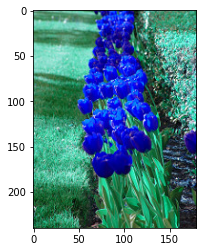

In [30]:
flower_dir = '/content/flower_photos'

class_names = sorted(os.listdir(flower_dir))
class_names

for category in class_names:
    print(category)
    path = os.path.join(flower_dir, category)
    print(path)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        plt.imshow(img_array)
        plt.show()
        break

In [58]:
flower_data = create_dataset(flower_dir)
flower_X, flower_y = extract_X_y(flower_data)
flower_train_X, flower_test_X, flower_train_y, flower_test_y = train_test_split(flower_X, flower_y, test_size=0.2)
flower_train_X.shape, flower_test_X.shape, flower_train_y.shape, flower_test_y.shape

/content/flower_photos/.ipynb_checkpoints
/content/flower_photos/daisy
/content/flower_photos/dandelion
/content/flower_photos/roses
/content/flower_photos/sunflowers
/content/flower_photos/tulips


((2936, 128, 128, 3), (734, 128, 128, 3), (2936,), (734,))

In [59]:
flower_model = None
model_flower= keras.models.clone_model(model)
model_flower.build((None, 128,128,3)) # replace 10 with number of variables in input layer
model_flower.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model_flower.set_weights(model.get_weights())

In [60]:

for layer in model_flower.layers:
    layer.trainable = False
model_flower.layers[-1].trainable = True
base_layers = model_flower.layers[-1].output
flower_model = keras.Model(inputs = model_flower.input, outputs = base_layers)
flower_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 128, 128, 16  64          ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 16  64          ['input_4[0][0]']                
                                )                                                           

In [61]:
flower_train_y =flower_train_y - 1


In [62]:
np.unique(flower_train_y)

array([0, 1, 2, 3, 4])

In [67]:
flower_train_y = to_categorical(flower_train_y ,num_classes=5)
flower_train_y

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [68]:

flower_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [69]:
start = time.time()
history = flower_model.fit(x=flower_train_X, y=flower_train_y, batch_size=64, epochs=50, validation_split=0.1,
                              callbacks=[keras.callbacks.TensorBoard()])
duration2 = time.time() - start

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


42/42 [==============================] - 3s 51ms/step - loss: 16.2039 - accuracy: 0.1866 - val_loss: 14.9686 - val_accuracy: 0.1973
Epoch 2/50
42/42 [==============================] - 2s 47ms/step - loss: 9.3992 - accuracy: 0.2157 - val_loss: 9.6957 - val_accuracy: 0.2279
Epoch 3/50
42/42 [==============================] - 2s 48ms/step - loss: 5.7377 - accuracy: 0.2627 - val_loss: 5.8631 - val_accuracy: 0.2585
Epoch 4/50
42/42 [==============================] - 2s 45ms/step - loss: 3.5793 - accuracy: 0.2793 - val_loss: 3.5880 - val_accuracy: 0.2687
Epoch 5/50
42/42 [==============================] - 2s 48ms/step - loss: 2.5729 - accuracy: 0.3047 - val_loss: 2.6323 - val_accuracy: 0.3163
Epoch 6/50
42/42 [==============================] - 2s 49ms/step - loss: 2.1322 - accuracy: 0.3236 - val_loss: 2.3755 - val_accuracy: 0.3129
Epoch 7/50
42/42 [==============================] - 2s 45ms/step - loss: 1.9352 - accuracy: 0.3520 - val_loss: 2.2062 - val_accuracy: 0.3367
Epoch 8/50
42/42 [====

In [70]:
for layer in flower_model.layers:
    layer.trainable = True

In [71]:
flower_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 128, 128, 16  64          ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 16  64          ['input_4[0][0]']                
                                )                                                           

In [73]:
start = time.time()
history2 = flower_model.fit(x=flower_train_X, y=flower_train_y, batch_size=32, epochs=40, validation_split=0.1,
                              callbacks=[keras.callbacks.TensorBoard()])
duration2 = time.time() - start

Epoch 1/40
83/83 [==============================] - 2s 27ms/step - loss: 1.2939 - accuracy: 0.4917 - val_loss: 2.0021 - val_accuracy: 0.3980
Epoch 2/40
83/83 [==============================] - 2s 24ms/step - loss: 1.3075 - accuracy: 0.4815 - val_loss: 1.9013 - val_accuracy: 0.3912
Epoch 3/40
83/83 [==============================] - 2s 26ms/step - loss: 1.3039 - accuracy: 0.4868 - val_loss: 1.9033 - val_accuracy: 0.3946
Epoch 4/40
83/83 [==============================] - 2s 26ms/step - loss: 1.3134 - accuracy: 0.4784 - val_loss: 1.9718 - val_accuracy: 0.3810
Epoch 5/40
83/83 [==============================] - 2s 25ms/step - loss: 1.3328 - accuracy: 0.4833 - val_loss: 1.9395 - val_accuracy: 0.3878
Epoch 6/40
83/83 [==============================] - 2s 26ms/step - loss: 1.3399 - accuracy: 0.4811 - val_loss: 2.0112 - val_accuracy: 0.3776
Epoch 7/40
83/83 [==============================] - 2s 24ms/step - loss: 1.3284 - accuracy: 0.4750 - val_loss: 2.6962 - val_accuracy: 0.3741
Epoch 8/40
83

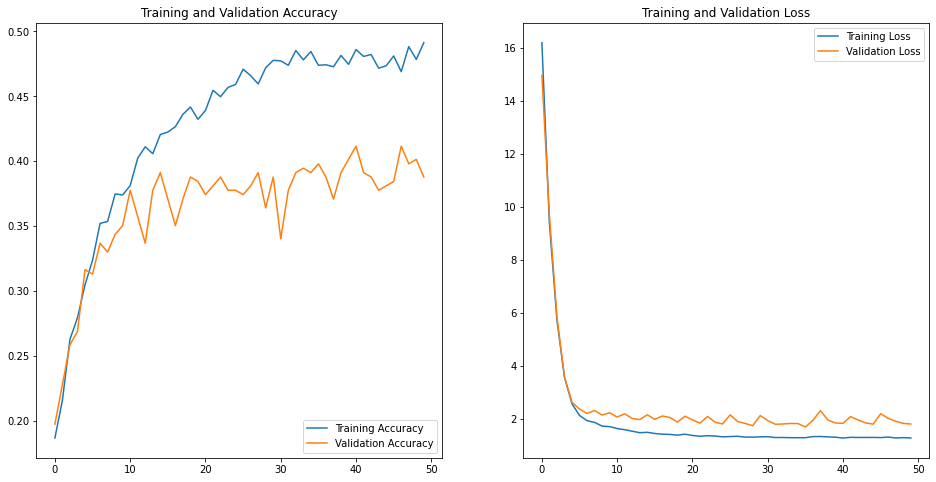

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

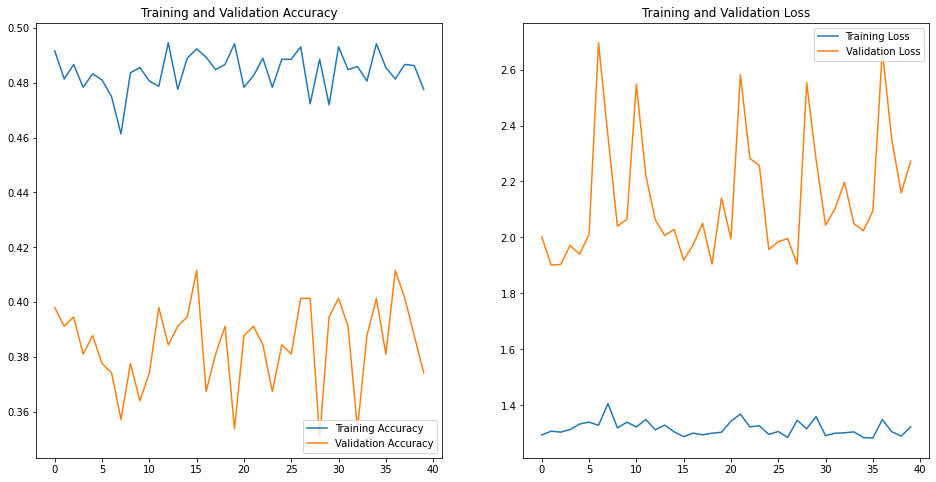

In [77]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [78]:
pred = flower_model.predict(flower_test_X)


23/23 [==============================] - 1s 34ms/step


In [79]:
pred = pred.argmax(axis=1)

In [80]:
flower_test_y = flower_test_y - 1

In [81]:
accuracy_score(flower_test_y, pred)

0.3555858310626703

In [82]:
confusion_matrix(flower_test_y, pred)

array([[39, 29, 39, 20,  2],
       [17, 80, 40, 38,  5],
       [ 8, 17, 63, 28, 12],
       [ 7, 22, 47, 59,  4],
       [ 5, 20, 84, 29, 20]])

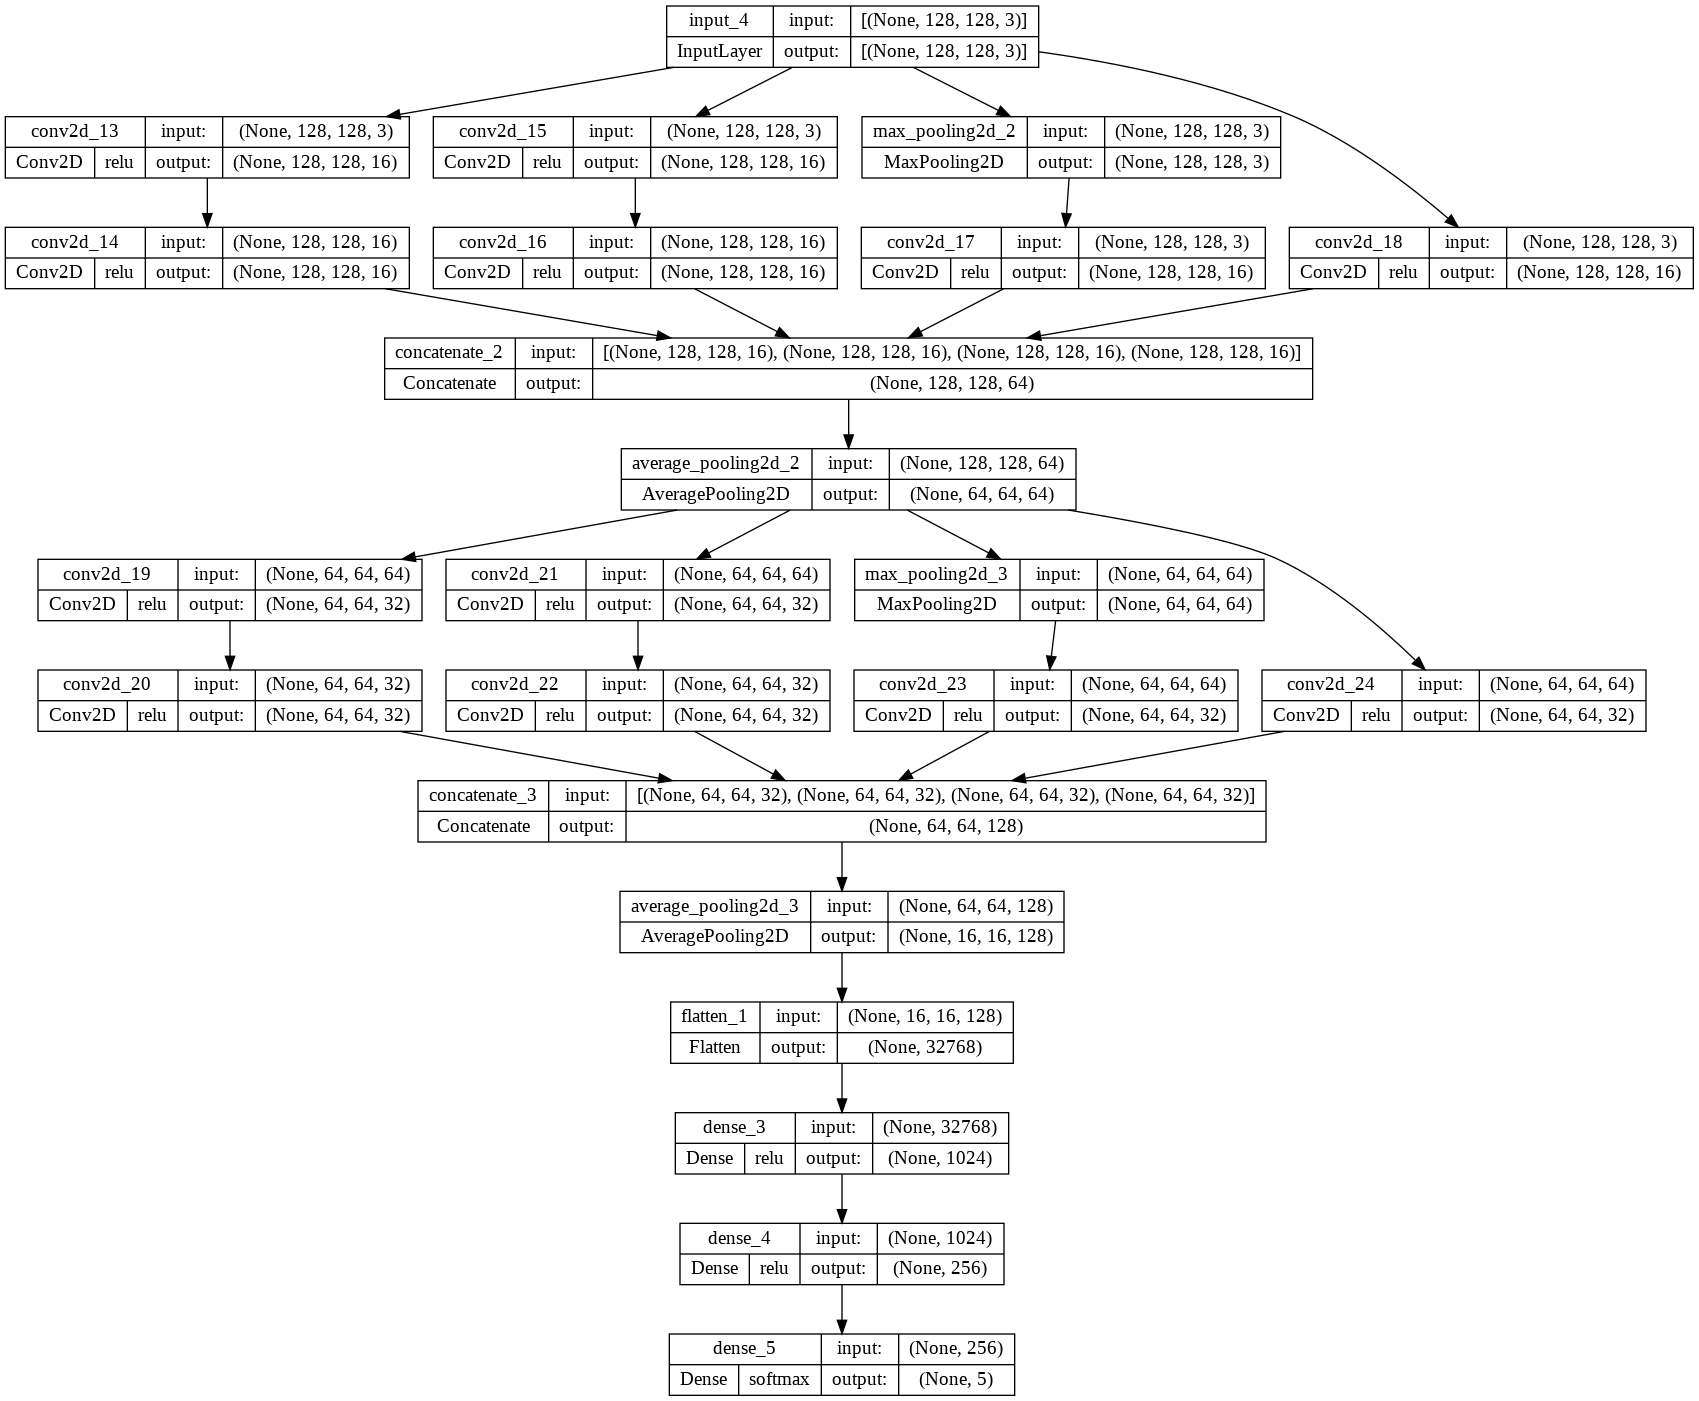

In [83]:
keras.utils.plot_model(flower_model, show_layer_activations=True, show_shapes=True, show_layer_names=True)